# Utility Plots

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.path.append('../../')
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=False)
rc('axes', edgecolor="black")

from src.classifier.parzen_window_classifier import PWC
from src.base.data_set import DataSet
from src.query_strategies.expected_probabilistic_active_learning import XPAL, xpal_gain
from src.query_strategies.probabilistic_active_learning import pal_gain, PAL
from src.query_strategies.uncertainty_sampling import US, uncertainty_scores
from src.query_strategies.expected_error_reduction import EER, expected_error_reduction
from src.query_strategies.query_by_committee import QBC, calc_avg_KL_divergence
from src.query_strategies.active_learnig_with_cost_embedding import ALCE, cost_sensitive_uncertainty
from src.query_strategies.mdsp import MDSP
from src.utils.evaluation_functions import misclf_rate

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_kernels
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import NearestNeighbors, KernelDensity


/home/marek/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Plot Functions

In [2]:
def plot_utilities_2d(X, y, X_1_mesh, X_2_mesh, labeled_indices, unlabeled_indices, scores, posteriors, algo=None, 
                      filename=None):
    fig = plt.figure(figsize=(5, 4.2))
    plt.box(True)
    plt.grid(b=None)
    plt.axis('on')
    if algo is not None:
        plt.title('Method {}'.format(algo))
    plt.xlim(min(X[:, 0]), max(X[:, 0]))
    plt.ylim(min(X[:, 1]), max(X[:, 1]))
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        direction='in',
        labelbottom=False, # labels along the bottom edge are off
        labelleft=False) # labels along the bottom edge are off
    
    plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=[[.2, .2, .2]], s=180, marker='o', zorder=3.8)
    plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=[[.8, .8, .8]], s=120, marker='o', zorder=4)
    for cl, marker in zip([0, 1],['D','s']):
        cl_labeled_idx = labeled_indices[y[labeled_indices] == cl]
        cl_unlabeled_idx = unlabeled_indices[y[unlabeled_indices] == cl]
        plt.scatter(X[cl_labeled_idx, 0], X[cl_labeled_idx, 1], c=np.ones(len(cl_labeled_idx))*cl, marker=marker, 
                    vmin=-0.2, vmax=1.2, cmap='coolwarm', s=40, zorder=5)
        plt.scatter(X[cl_unlabeled_idx, 0], X[cl_unlabeled_idx, 1], c=np.ones(len(cl_unlabeled_idx)) * cl, 
                    marker=marker, vmin=-0.2, vmax=1.2, cmap='coolwarm', s=40, zorder=3)
        plt.scatter(X[cl_unlabeled_idx, 0], X[cl_unlabeled_idx, 1], c='k', marker=marker, vmin=-0.1, vmax=1.1, 
                    cmap='coolwarm', s=60, zorder=2.8)
    
    plt.contourf(X_1_mesh, X_2_mesh, scores, cmap='Greens', alpha=.75)
    plt.contour(X_1_mesh, X_2_mesh, posteriors, [.49, .51], cmap='coolwarm', linewidths=[4, 4], 
                     zorder=1, alpha=.8, vmin=.488, vmax=.512)
    plt.contour(X_1_mesh, X_2_mesh, posteriors, [.5], colors='k', linewidths=[2], zorder=1)
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig('../../images/{}.pdf'.format(filename), bbox_inches='tight')
    plt.show()
    
    return fig
    
    
def create_2d_data_set(seed=42, res=21):
    X, y = make_blobs(n_samples=100, n_features=2, centers=[[0,1],[-3,.5],[-1,-1],[2,1],[1,-.5]], cluster_std=.7, 
                      random_state=seed)
    y = y % 2
    X = StandardScaler().fit_transform(X)
    x_1_vec = np.linspace(min(X[:, 0]), max(X[:, 0]), res)
    x_2_vec = np.linspace(min(X[:, 1]), max(X[:, 1]), res)
    X_1_mesh, X_2_mesh = np.meshgrid(x_1_vec, x_2_vec)
    mesh_instances = np.array([X_1_mesh.reshape(-1), X_2_mesh.reshape(-1)]).T
    return X, y, X_1_mesh, X_2_mesh, mesh_instances


def al_cycle_2d(X, y, budget=30, method='lc', seed=42):    
    n_samples = np.size(X, 0)
    n_features = np.size(X, 1)
    
    # set parameters
    nominator = 2 * n_samples * n_features
    denominator = (n_samples - 1) * np.log((n_samples - 1) / ((np.sqrt(2) * 10 ** -6) ** 2))
    bandwidth = np.sqrt(nominator / denominator)
    print(bandwidth)
    gamma = 0.5 * (bandwidth ** (-2))
    
    # create parzen window classifier
    n_classes = len(np.unique(y))
    pwc = PWC(n_classes=n_classes, metric='rbf', gamma=gamma)
    
    # compute similarities
    S = pairwise_kernels(X, X, metric='rbf', gamma=gamma)
    
    # create data set
    data = DataSet(X)
    
    # create selection strategy with given parameters and data
    if method in ['lc', 'sm', 'entropy']:
        selection_strategy = US(data_set=data, model=pwc, method=method, random_state=seed)
    elif method in ['log-loss', 'zero-one-loss']:
        selection_strategy = EER(data_set=data, n_classes=n_classes, model=pwc, method=method, random_state=seed, 
                                 eps=0.001)
    elif method == 'pal':
        kde_dens = KernelDensity(bandwidth=bandwidth, kernel='gaussian').fit(X)
        densities = np.exp(kde_dens.score_samples(X))
        selection_strategy = PAL(data_set=data, n_classes=n_classes, S=S, densities=densities, alpha_c=1, m_max=2, 
                                 random_state=seed)
    elif method == 'xpal':
        selection_strategy = XPAL(data_set=data, n_classes=n_classes, S=S, alpha_c=0.001, alpha_x=0.001, 
                                  random_state=seed)
    elif method == 'alce':
        C = 1 - np.eye(n_classes)
        selection_strategy = ALCE(data_set=data, base_regressor=KernelRidge(kernel='rbf', gamma=gamma), C=C, 
                                  random_state=seed)
    elif method == 'qbc':
        selection_strategy = QBC(data_set=data, model=pwc, random_state=seed)
    else:
        raise ValueError('method {} not existing'.format(method))
        
    # execute active learning cycles
    labeled = []
    errors = []
    for b in range(budget):
        # select sample
        sample_id = selection_strategy.make_query()

        # update training data
        data.update_entries(sample_id, y[sample_id])

        # update statistics
        labeled.append(sample_id[0])
        pwc.fit(X[labeled], y[labeled])
        y_pred = pwc.predict(X)
        errors.append(misclf_rate(y_true=y, y_pred=y_pred))
            
    return np.array(labeled, np.int), errors


def plot_utilities_data_set(method, label_fraction, al, seed):
    
    # create data set
    X, y, X_1_mesh, X_2_mesh, mesh_instances = create_2d_data_set(seed=seed, res=101)
    n_classes = len(np.unique(y))
    n_samples = np.size(X, 0)
    n_features = np.size(X, 1)
    
    # set parameters
    nominator = 2 * n_samples * n_features
    denominator = (n_samples - 1) * np.log((n_samples - 1) / ((np.sqrt(2) * 10 ** -6) ** 2))
    bandwidth = np.sqrt(nominator / denominator)
    gamma = 0.5 * (bandwidth ** (-2))
    
    # acquire labels
    budget = int(label_fraction * len(X))
    if al:
        labeled_indices, mcl_costs = al_cycle_2d(X=X, y=y, budget=budget, method=method, seed=2)
    else:
        labeled_indices = np.random.RandomState(11).choice(np.arange(len(X)), size=budget, replace=False)
    
    unlabeled_indices = np.setdiff1d(range(len(X)), labeled_indices)

    # compute uncertainty scores
    pwc = PWC(n_classes=n_classes, metric='rbf', gamma=gamma, random_state=seed).fit(X[labeled_indices], 
                                                                                     y[labeled_indices])
    P = pwc.predict_proba(mesh_instances, normalize=True)
    if method in ['lc', 'sm', 'entropy']:
        scores = uncertainty_scores(P=P, method=method)
    elif method in ['log-loss', 'zero-one-loss']:
        scores = -expected_error_reduction(model=pwc, X_labeled=X[labeled_indices], y_labeled=y[labeled_indices], 
                                          X_unlabeled=mesh_instances, method=method, eps=0.001)
    elif method == 'pal':
        kde_dens = KernelDensity(bandwidth=bandwidth, kernel='gaussian').fit(X)
        densities = np.exp(kde_dens.score_samples(mesh_instances))
        K = pwc.predict_proba(mesh_instances, normalize=False)
        scores = densities * pal_gain(K_c=K, m_max=2, alpha_c=1)
    elif method == 'xpal':
        S = pairwise_kernels(mesh_instances, X, metric='rbf', gamma=gamma)
        K_c = pwc.predict_proba(mesh_instances, normalize=False)
        K_x = pwc.predict_proba(X, normalize=False)
        scores = xpal_gain(K_c=K_c, K_x=K_x, S=S, alpha_x=0.001, alpha_c=0.001)
    elif method == 'alce':
        C = 1 - np.eye(n_classes)
        nn = NearestNeighbors(n_neighbors=1)
        dissimilarity = np.zeros((2 * n_classes, 2 * n_classes))
        dissimilarity[:n_classes, n_classes:] = C
        dissimilarity[n_classes:, :n_classes] = C.T
        mds_params = {
                'metric': False,
                'n_components': n_classes,
                'n_uq': n_classes,
                'max_iter': 300,
                'eps': 1e-6,
                'dissimilarity': "precomputed",
                'n_init': 8,
                'n_jobs': 1,
                'random_state': seed
        }
        mds = MDSP(**mds_params)
        embedding = mds.fit(dissimilarity).embedding_

        class_embed = embedding[:n_classes, :]
        nn.fit(embedding[n_classes:, :])
        regressors = [copy.deepcopy(KernelRidge(kernel='rbf', gamma=gamma)) for _ in range(n_classes)]
        scores = cost_sensitive_uncertainty(X_unlabeled=mesh_instances, X_labeled=X[labeled_indices], 
                                            y_labeled=y[labeled_indices], nn=nn, regressors=regressors, 
                                            class_embed=class_embed, embed_dim=n_classes)
    elif method == 'qbc':
        scores = calc_avg_KL_divergence(model=pwc, X_labeled=X[labeled_indices], y_labeled=y[labeled_indices], 
                                        X_unlabeled=mesh_instances, random_state=0)
    else:
        raise ValueError('method {} not existing'.format(method))
        
    scores = scores.reshape(X_1_mesh.shape)
    
    # compute decision boundary
    errors = P @ (1 - np.eye(n_classes))
    errors /= np.sum(errors, axis=1, keepdims=True)
    posteriors = errors[:, 0].reshape(X_1_mesh.shape)
    
    algo_names = {'pal': 'PAL', 'alce': 'ALCE', 'qbc': 'QBC', 'lc': 'US', 
                  'xpal': r'xPAL$(\mathbf{\alpha}=\mathbf{10^{-3}})$', 'zero-one-loss': 'EER'
                 }
    
    # plot gains and decision boundary
    filename = method if al else method+'-no-al'
    plot_utilities_2d(X=X, y=y, X_1_mesh=X_1_mesh, X_2_mesh=X_2_mesh, unlabeled_indices=unlabeled_indices, 
                   labeled_indices=labeled_indices,  scores=scores, posteriors=posteriors, algo=algo_names[method],
                   filename=filename)

## Generate Utility Plots

In [6]:
plot_utilities_data_set(method='xpal', label_fraction=0.08, al=1, seed=1)
plot_utilities_data_set(method='pal', label_fraction=0.08, al=1, seed=1)
plot_utilities_data_set(method='lc', label_fraction=0.08, al=1, seed=1)
plot_utilities_data_set(method='alce', label_fraction=0.08, al=1, seed=1)
plot_utilities_data_set(method='zero-one-loss', label_fraction=0.08, al=1, seed=1)
plot_utilities_data_set(method='qbc', label_fraction=0.08, al=1, seed=1)

0.3579561231134134
0.001
#decision_flips: 10000
#decision_flips: 2848
#decision_flips: 2112
#decision_flips: 1618
#decision_flips: 1191
#decision_flips: 1075
#decision_flips: 931
#decision_flips: 787
#decision_flips: 51044


KeyboardInterrupt: 

#decision_flips: 67167


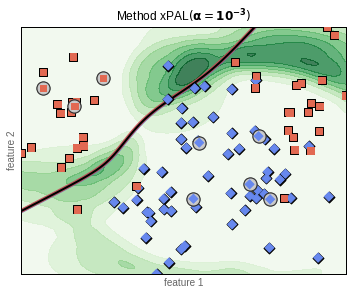

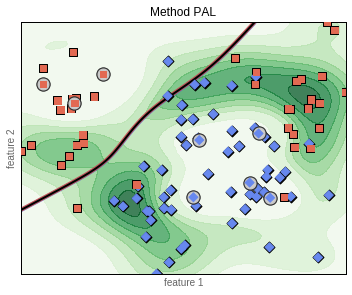

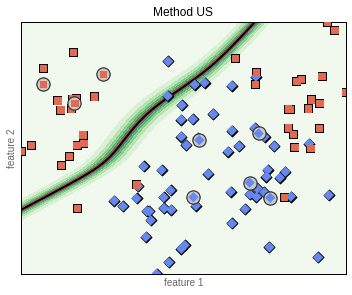

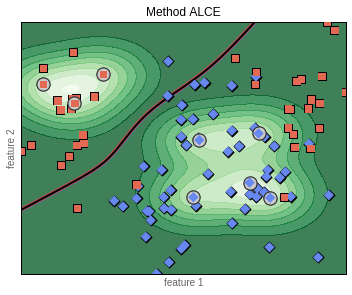

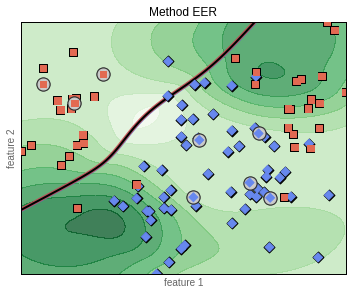

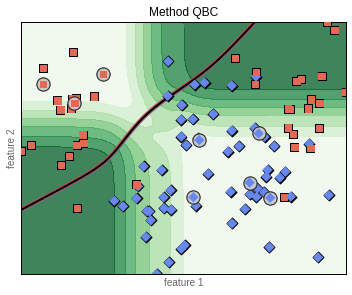

In [3]:
plot_utilities_data_set(method='xpal', label_fraction=0.08, al=0, seed=1)
plot_utilities_data_set(method='pal', label_fraction=0.08, al=0, seed=1)
plot_utilities_data_set(method='lc', label_fraction=0.08, al=0, seed=1)
plot_utilities_data_set(method='alce', label_fraction=0.08, al=0, seed=1)
plot_utilities_data_set(method='zero-one-loss', label_fraction=0.08, al=0, seed=1)
plot_utilities_data_set(method='qbc', label_fraction=0.08, al=0, seed=1)